In [1]:
import io
import numpy as np

from PIL import Image, ImageDraw as D

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import argparse
import math
import random
import shutil
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.transforms

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

from compressai.datasets import ImageFolder
from compressai.zoo import mbt2018

from piq import psnr

import os

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [2]:
image_filename = 'c0020'
basedir = '/Users/clemens/vsc-data/'

image_original = Image.open(basedir + 'test_images/' + image_filename + '.png').convert('RGB')

#image_supersampled = Image.open(basedir + 'bicubic_supersampled/' + image_filename + '_x2_SR.png').convert('RGB')

image = {
    'q4_mse': Image.open(basedir + 'mbt2018_q4_mse_fullres/' + image_filename + '.png').convert('RGB'),
    'q4_msssim': Image.open(basedir + 'mbt2018_q4_msssim_fullres/' + image_filename + '.png').convert('RGB'),
    #'q4_m': Image.open(basedir + 'mbt2018_q4_mse_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    #'q4_msss': Image.open(basedir + 'mbt2018_q4_msssim_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    'q6_mse': Image.open(basedir + 'mbt2018_q6_mse_fullres/' + image_filename + '.png').convert('RGB'),
    'q6_msssim': Image.open(basedir + 'mbt2018_q6_msssim_fullres/' + image_filename + '.png').convert('RGB'),
    #'q6_m': Image.open(basedir + 'mbt2018_q6_mse_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    #'q6_msss': Image.open(basedir + 'mbt2018_q6_msssim_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    'q8_mse': Image.open(basedir + 'mbt2018_q8_mse_fullres/' + image_filename + '.png').convert('RGB'),
    'q8_msssim': Image.open(basedir + 'mbt2018_q8_msssim_fullres/' + image_filename + '.png').convert('RGB'),
    #'q8_m': Image.open(basedir + 'mbt2018_q8_mse_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    #'q8_msss': Image.open(basedir + 'mbt2018_q8_msssim_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB')
}

pilToTensor = transforms.Compose([transforms.PILToTensor()])

In [3]:
device = "cpu"
model = "mbt2018"
suffix = "_500ep"

directory = '/Users/clemens/vsc-data/test_images'
x2dir = '/Users/clemens/vsc-data/test_images_x2'


bpp = {
#    'q4mse': 0,
#    'q4msssim': 0,
#    'q6mse': 0,
#    'q6msssim': 0,
#    'q8mse': 0,
#    'q8msssim': 0
}
psnr_results = {
#    'q4mse': 0,
#    'q4msssim': 0,
#    'q6mse': 0,
#    'q6msssim': 0,
#    'q8mse': 0,
#    'q8msssim': 0
}
msssim_results = {
    'q4mse': 0,
    'q4msssim': 0,
    'q6mse': 0,
    'q6msssim': 0,
    'q8mse': 0,
    'q8msssim': 0
}
lambdas = {
    'q4mse': 845,
    'q4msssim': 16.65,
    'q6mse': 3140,
    'q6msssim': 60.5,
    'q8mse': 11705,
    'q8msssim': 220
}

def pad (x):
    h, w = x.size(2), x.size(3)
    p = 64  # maximum 6 strides of 2
    new_h = (h + p - 1) // p * p
    new_w = (w + p - 1) // p * p
    padding_left = (new_w - w) // 2
    padding_right = new_w - w - padding_left
    padding_top = (new_h - h) // 2
    padding_bottom = new_h - h - padding_top
    return F.pad(
        x,
        (padding_left, padding_right, padding_top, padding_bottom),
        mode="constant",
        value=0,
    )

for quality in [4, 6, 8]:
    for metric in ['mse', 'msssim']:
        net = mbt2018(quality=quality, pretrained=False).eval().to(device)
        file = "/Users/clemens/vsc-data/mbt/" + model + "_q" + str(quality) + "_" + metric + suffix + ".pth.tar"
        print(file)
        checkpoint = torch.load(file, map_location=device)
        net.load_state_dict(checkpoint["state_dict"])
        print("Actual epochs:" + str(checkpoint["epoch"] + 1))

        filename = os.path.join(directory, image_filename + '.png')
        if filename.endswith(".png"):
            print(filename)
            img = Image.open(filename).convert('RGB')
            x = transforms.ToTensor()(img).unsqueeze(0).to(device)
            x = pad(x)
            
            with torch.no_grad():
                out_net = net.forward(x)
            out_net['x_hat'].clamp_(0, 1)
            width, height = img.size
            num_pixels = 3 * width * height
            bpp["q"+str(quality)+metric] = sum(
                (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
                for likelihoods in out_net["likelihoods"].values()
            ).item()
            crop_x = int((out_net["x_hat"].size()[3] - width) / 2)
            crop_y = int((out_net["x_hat"].size()[2] - height) / 2)
            psnr_results["q"+str(quality)+metric] = psnr(out_net["x_hat"][:, :, crop_y:(height+crop_y), crop_x:(width+crop_x)], pilToTensor(img).unsqueeze(0) / 255.0, data_range=1.0).item()
            msssim_results["q"+str(quality)+metric] = ms_ssim(out_net["x_hat"][:, :, crop_y:(height+crop_y), crop_x:(width+crop_x)], pilToTensor(img).unsqueeze(0) / 255.0, data_range=1.0, size_average=True).item()

/Users/clemens/vsc-data/mbt/mbt2018_q4_mse_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0020.png
/Users/clemens/vsc-data/mbt/mbt2018_q4_msssim_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0020.png
/Users/clemens/vsc-data/mbt/mbt2018_q6_mse_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0020.png
/Users/clemens/vsc-data/mbt/mbt2018_q6_msssim_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0020.png
/Users/clemens/vsc-data/mbt/mbt2018_q8_mse_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0020.png
/Users/clemens/vsc-data/mbt/mbt2018_q8_msssim_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0020.png


In [4]:
print(bpp)
print(psnr_results)
print(msssim_results)

{'q4mse': 0.16617126762866974, 'q4msssim': 0.14914380013942719, 'q6mse': 0.3364449739456177, 'q6msssim': 0.26761117577552795, 'q8mse': 0.6233980059623718, 'q8msssim': 0.4716002345085144}
{'q4mse': 29.980022430419922, 'q4msssim': 28.078166961669922, 'q6mse': 33.1177864074707, 'q6msssim': 30.017227172851562, 'q8mse': 37.473419189453125, 'q8msssim': 33.24566650390625}
{'q4mse': 0.9728384613990784, 'q4msssim': 0.9774344563484192, 'q6mse': 0.9892547726631165, 'q6msssim': 0.9886565804481506, 'q8mse': 0.9963063597679138, 'q8msssim': 0.9951384663581848}


In [16]:
image_original = Image.open(basedir + 'test_images/' + image_filename + '.png').convert('RGB')

1914x1052
1914x1052
1914x1052
1914x1052
1914x1052
1914x1052


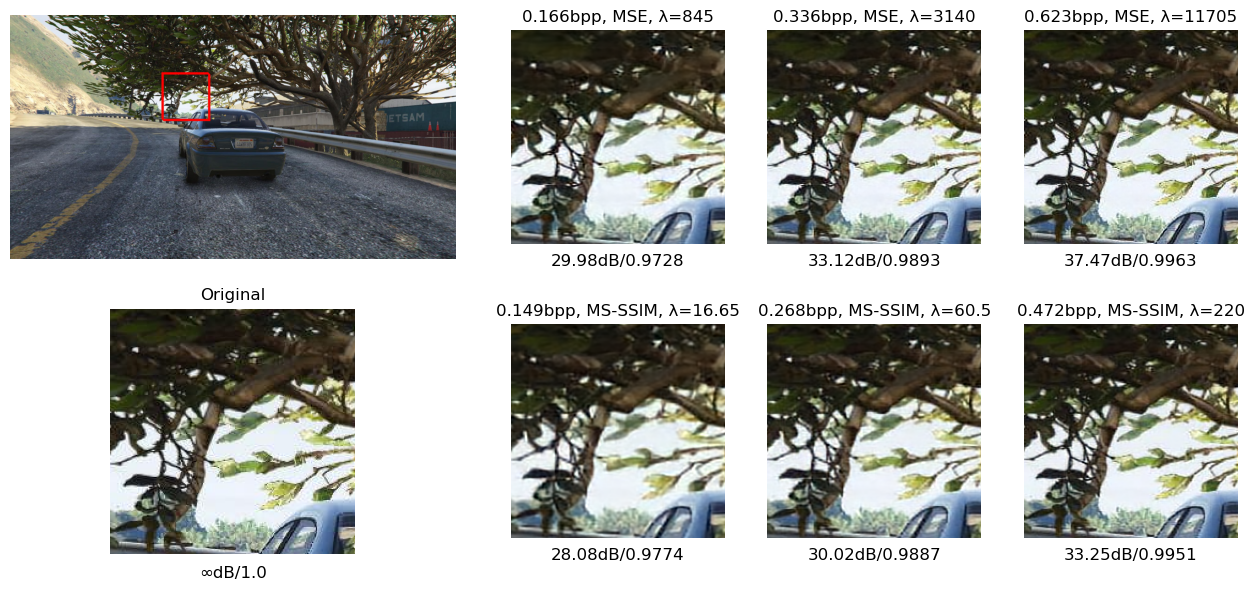

In [17]:
%matplotlib inline

#fix, axes = plt.subplots(2, 7, figsize=(16, 12))
fig = plt.figure(figsize=(16, 7))
gs = GridSpec(2,5)
x1 = 650
y1 = 250
x2 = 850
y2 = 450
crop = (x1, y1, x2, y2)

#print(axes.shape)
#for ax in axes:
#    for a in ax:
#        a.axis('off')

#original_span = axes[1, 2].get_gridspec()
rect = fig.add_subplot(gs[1,0:2])
rect.imshow(image_original.crop(crop))
rect.title.set_text('Original')
rect.text(0.5,-0.1, '\u221EdB/1.0', size=12, ha="center", transform=rect.transAxes)
rect.axis('off')

draw=D.Draw(image_original)
width = 10
cor = crop
for i in range(width):
    draw.rectangle(cor, outline="red")   
    cor = (cor[0]+1,cor[1]+1, cor[2]+1,cor[3]+1)

main = fig.add_subplot(gs[0,0:2])
main.imshow(image_original)
main.axis('off')
#main.title.set_text('Original')

#rect = fig.add_subplot(gs[2,1])
#rect.imshow(image_supersampled.crop(crop))
#rect.title.set_text('Supersampled')
#rect.text(0.5,-0.1, str(round(psnr_ss, 3)) + 'dB/' + str(round(msssim_ss, 4)), size=12, ha="center", transform=rect.transAxes)
#rect.axis('off')

for quality in [4,6,8]:
    for metric in ['mse', 'msssim']:
        y_axis = 0 if metric == 'mse' else 1
        print(str(image['q' + str(quality) + '_' + metric].width) + 'x' + str(image['q' + str(quality) + '_' + metric].height))
        rect = fig.add_subplot(gs[y_axis, int(quality/2)])
        rect.imshow(image['q' + str(quality) + '_' + metric].crop(crop))
        rect.title.set_text(
            str(round(bpp["q"+str(quality)+metric],3)) + 'bpp, ' + ('MSE' if metric == 'mse' else 'MS-SSIM') + ', λ=' + str(lambdas["q"+str(quality)+metric])
        )
        rect.text(0.5,-0.1, str(round(psnr_results["q"+str(quality)+metric],2)) + 'dB/' + str(round(msssim_results["q"+str(quality)+metric],4)), size=12, ha="center", transform=rect.transAxes)
        rect.axis('off')

plt.savefig('/Users/clemens/Documents/Bachelor Thesis/ba-thesis/graphics/sample-image-1-compression.pdf', pad_inches=-1)